# A/A/B Test Project for a Food-Selling Start-Up

I am going to investigate user behavior for the company's app.
I'll study the sales funnel, find out how users reach the purchase stage and then I'll look at the results of an A/A/B test in order to find out which set of fonts used in the app's design produces better results.

#### The data

The `data` file contains the following info:

`EventName` — event name

`DeviceIDHash` — unique user identifier

`EventTimestamp` — event time

`ExpId` — experiment number: 246 and 247 are the control groups, 248 is the test group

#### Libraries to use

In [58]:
import pandas as pd

import datetime as dt

import numpy as np 

import scipy.stats as stats

from statsmodels.stats.weightstats import ztest as ztest

import datetime

import random

import math as mth

import matplotlib.pyplot as plt

import plotly.express as px

from plotly import graph_objects as go

import seaborn as sns
sns.set()

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Opening  the data file and reading the general information

In [59]:
data = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')
data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [60]:
pd.options.display.max_colwidth = 100
data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Preparing the data for analysis

Let's crete separate columns based on the initial one

Let's extract date and time data from the timestamp column

In [61]:
data['Date_Time'] = pd.to_datetime(data['EventTimestamp'], unit='s', errors='coerce')
data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId,Date_Time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


Let's create a separate column with dates only

In [62]:
data['Date'] = data['Date_Time'].dt.date
data['Date'] = pd.to_datetime(data['Date'])
data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId,Date_Time,Date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Let's rename columns for better convenience

In [63]:
data = data.rename(columns={"EventName": "event_name", "DeviceIDHash": "user_id", 'EventTimestamp': 'event_timestamp', 'ExpId':'test_n', 'Date_Time':'date_time', 'Date': 'date'})
data.head(5)

,event_name,user_id,event_timestamp,test_n,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   user_id          244126 non-null  int64         
 2   event_timestamp  244126 non-null  int64         
 3   test_n           244126 non-null  int64         
 4   date_time        244126 non-null  datetime64[ns]
 5   date             244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


Let's drop duplicates, if there are any

In [65]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   test_n           243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


About 400 duplicated rows dropped out.
Now data is clean, renamed and enriched enough to proceed to the analysis itself.

### Studying and check the data

I this part I am going to find the following information :
- The number of events in the logs;
- The number of users in the logs;
- The average number of events per user;
- The period of time does the data cover. 
- Did you lose many events and users when excluding the older data?
- Make sure you have users from all three experimental groups.

#### Number of events in the logs

In [66]:
data['event_name'].count()

243713

There are 243713 in the logs

#### Number of unique users in the logs

In [67]:
data['user_id'].nunique()

7551

There are 7551 unique users in the logs

#### Average number of events per user?

In [68]:
np.round(np.int(data['event_name'].count()) / np.int(data['user_id'].nunique()))

32.0

There are 32 events per user on average 

#### Time cover

In [69]:
data['date'].describe()

count                  243713
unique                     14
top       2019-08-01 00:00:00
freq                    36141
first     2019-07-25 00:00:00
last      2019-08-07 00:00:00
Name: date, dtype: object

The data covers events from 25.07.2019 till 07.08.2019

Let's build a graph

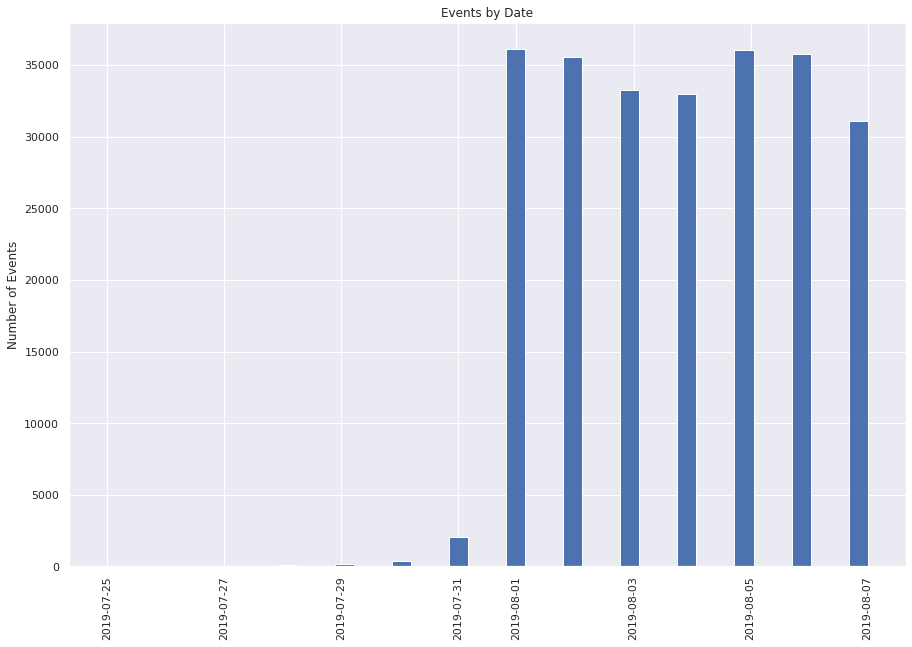

In [70]:
ax = data['date'].hist(bins=40, figsize=(15, 10))
plt.title('Events by Date')
ax.set_ylabel('Number of Events')
plt.xticks(rotation='vertical')
plt.show()

From the graph, we can see that in fact there is almost no complete data till 1.08.2019. We can exclude the earlier events.

In [71]:
data_new = data[data['date'] > '2019-07-31']
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       240887 non-null  object        
 1   user_id          240887 non-null  int64         
 2   event_timestamp  240887 non-null  int64         
 3   test_n           240887 non-null  int64         
 4   date_time        240887 non-null  datetime64[ns]
 5   date             240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 12.9+ MB


In [72]:
data_new

,event_name,user_id,event_timestamp,test_n,date_time,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [73]:
data_new['user_id'].nunique() 

7534

After cutting the data that preceeds the 1.08.2019, only 17 unique users and nearly 2800 events were lost.

In [74]:
np.round(np.int(data_new['event_name'].count()) / np.int(data_new['user_id'].nunique()))

32.0

We need to check whether all 3 test group are represented in new dataset

In [75]:
data_new['test_n'].nunique()

3

Intermediate conclusion:

    - There are 243713 events and 7551 unique users represented in the initial logs;
    - 32 events per user are performed;
    - After cut by dates, there are 240887 events and 7534 users represented in the logs.
    - Still 32 events per user are performed after data cut;
    - All 3 groups are still represented after cut.

### Studying the event funnel

Here, I'm going to do the following:

- See what events are in the logs and their frequency of occurrence;
- Find the number of users who performed each of these actions. Calculate the proportion of users who performed the action at least once;
- Understand the event funnel;
- Use the event funnel to find the share of users that proceed from each stage to the next;
- Find the stage where users are lost mostly;
- Find the share of users that make the entire journey from their first event to payment.


#### Events and their frequency of occurrence

Let's group the data by events and fing their frequency.

In [76]:
data_new['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [77]:
data_by_events = data_new.groupby(["event_name"])['user_id'].count().reset_index()
data_by_events = data_by_events.rename(columns={'user_id':'frequency'}).sort_values(by='frequency', ascending=False)
data_by_events

,event_name,frequency
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


#### Users

In [78]:
data_by_users = data_new.groupby(["event_name"])['user_id'].nunique().reset_index()
data_by_users = data_by_users.rename(columns={'user_id':'unique_users'}).sort_values(by='unique_users', ascending=False)
data_by_users

,event_name,unique_users
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [79]:
data_by_users['unique_users']

1    7419
2    4593
0    3734
3    3539
4     840
Name: unique_users, dtype: int64

Let's calculate the proportion of users who performed the action at least once.

In [80]:
data_by_users['user_prop%'] = ((data_by_users['unique_users']) / (data_new['user_id'].nunique())*100).round(1)
data_by_users = data_by_users.reset_index()
data_by_users

,index,event_name,unique_users,user_prop%
0,1,MainScreenAppear,7419,98.5
1,2,OffersScreenAppear,4593,61.0
2,0,CartScreenAppear,3734,49.6
3,3,PaymentScreenSuccessful,3539,47.0
4,4,Tutorial,840,11.1


#### Event funnel

Tutorial screen is not necceserily the part of the purchasing sequence.
So, logically. the order should be like this:
1. Main screen appear
2. Offer screen appear 
3. Cart screen appear
4. Payment screen successful

Apparently, not all of our unique users started the process from logically "first" event in sequence. Probably, that's why we see only 98.5% at the first stage.

In [81]:
event_funnel = data_by_users.drop([4])
event_funnel

,index,event_name,unique_users,user_prop%
0,1,MainScreenAppear,7419,98.5
1,2,OffersScreenAppear,4593,61.0
2,0,CartScreenAppear,3734,49.6
3,3,PaymentScreenSuccessful,3539,47.0


Let's take a look at the shares of people at every stage in relation to the initial number of users

In [82]:
fig = go.Figure(go.Funnel(
    y = event_funnel["event_name"],
    x = event_funnel['unique_users'], textinfo = "label+value+percent initial"))
fig.update_layout(title='Events Funnel by Number of Users')
fig.show()

48% of initial users  make the entire journey from their first event to payment

Let's calculate the share of users that proceeds from event to event

In [83]:
share=[100]
for j in range(1,len(event_funnel['unique_users'])):
    share.append(int(round(event_funnel['unique_users'][j]/event_funnel['unique_users'][j-1]*100)))

In [84]:
share

[100, 62, 81, 95]

In [85]:
event_funnel['share_that_proceeds%'] = share
event_funnel

,index,event_name,unique_users,user_prop%,share_that_proceeds%
0,1,MainScreenAppear,7419,98.5,100
1,2,OffersScreenAppear,4593,61.0,62
2,0,CartScreenAppear,3734,49.6,81
3,3,PaymentScreenSuccessful,3539,47.0,95


Intemediate conslusion:

    - 48% of initial users  make the entire journey from their first event to payment;
    - Most users (38%) are lost between the Main Screen and the Offers Screen stages;
    - Almost all of the users who make it to the Cart stage, proceed to the Payment stage.

### Studying the results of the experiment

We need to reveal the following:
- The number of users in each group;
- Find their share of users in each group who performed each action;
- Determine wether the groups were split properly;
- Check whether the difference between the groups is statistically significant;
- Compare the results with the combined results for the control groups.


#### Let's take a look at the number of people in each test group

In [86]:
data_by_test = data_new.groupby(['test_n'])['user_id'].nunique()
data_by_test

test_n
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

In [107]:
control_group246 = data_new[data_new['test_n'] == '246']
control_group247 = data_new[data_new['test_n'] == '247']
control_group248 = data_new[data_new['test_n'] == '248']

#### Let's find the frequencies of each event for every test group and share of users that made it through at each stage for every group.

In [108]:
control_group246_grouped = control_group246.groupby(["event_name"])['user_id'].nunique().reset_index()
control_group246_grouped = control_group246_grouped.rename(columns={'user_id':'unique_users'}).sort_values(by='unique_users', ascending=False)

In [109]:
control_group246_grouped['user_prop%'] = ((control_group246_grouped['unique_users']) / (control_group246['user_id'].nunique())*100).round(1)
control_group246_grouped = control_group246_grouped.reset_index()

In [110]:
control_group247_grouped = control_group247.groupby(["event_name"])['user_id'].nunique().reset_index()
control_group247_grouped = control_group247_grouped.rename(columns={'user_id':'unique_users'}).sort_values(by='unique_users', ascending=False)

In [111]:
control_group247_grouped['user_prop%'] = ((control_group247_grouped['unique_users']) / (control_group247['user_id'].nunique())*100).round(1)
control_group247_grouped = control_group247_grouped.reset_index()

In [112]:
control_group248_grouped = control_group248.groupby(["event_name"])['user_id'].nunique().reset_index()
control_group248_grouped = control_group248_grouped.rename(columns={'user_id':'unique_users'}).sort_values(by='unique_users', ascending=False)

In [113]:
control_group248_grouped['user_prop%'] = ((control_group248_grouped['unique_users']) / (control_group248['user_id'].nunique())*100).round(1)
control_group248_grouped = control_group248_grouped.reset_index()

Now we can check whether the difference between the groups is statistically significant

Let's combine all tests' data into one table for better clarity

In [114]:
table1 = control_group246_grouped.merge(control_group247_grouped, on='event_name', how='left')
all_tests = table1.merge(control_group248_grouped, on='event_name', how='left')
all_tests = all_tests.rename(columns={'unique_users_x': 'unique_users_246', 'unique_users_y':'unique_users_247', 'unique_users': 'unique_users_248', 
                                      'user_prop%_x':'user_prop%_246', 'user_prop%_247':'user_prop%_247', 'user_prop%':'user_prop%_248'}).drop(columns=['index_x', 'index_y', 'index'])

,unique_users_246,user_prop%_246,unique_users_247,user_prop%_y,event_name,unique_users_248,user_prop%_248


In [116]:
all_tests['control_groups_sum'] = all_tests['unique_users_246']+all_tests['unique_users_247']

#### Let's compare proportions of changes in users in our groups 

Hereinafter, I use proportion equality testing.

Null hypothesis: "There is no reason to consider the proportions different".

Alternative hypothesis: "There is a significant difference between the proportions"

Let's set the significance level at 5% for now.

In [97]:
alpha = 0.05

Let's make a pivot table with the groups events and unique users 

In [98]:
pivot = data_new.pivot_table(index='event_name', values='user_id', columns='test_n', aggfunc=lambda x: x.nunique()).reset_index()
pivot

test_n,event_name,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [99]:
def check_hypothesis(group1,group2, event, alpha=0.05):
    successes1=pivot[pivot.event_name==event][group1].iloc[0]
    successes2=pivot[pivot.event_name==event][group2].iloc[0]
    
    trials1=data_new[data_new.test_n==group1]['user_id'].nunique()
    trials2=data_new[data_new.test_n==group2]['user_id'].nunique()

    

    p1 = successes1/trials1

    p2 = successes2/trials2

    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Reject null-hypothesis for",event, 'and groups',group1,group2)
    else:
        print("Fail to Reject null-hypothesis for", event,'and groups',group1,group2) 

Let's check the function by comparing proportions between the first and the second control groups upon the Main Screen event

In [100]:
check_hypothesis(246,247, 'MainScreenAppear', alpha=0.05)

p-value:  0.7570597232046099
Fail to Reject null-hypothesis for MainScreenAppear and groups 246 247


Now we can make a loop to run the function comparing proportions between all corresponding events of two groups.

In [101]:
for i in pivot.event_name.unique():
    check_hypothesis(246,248, i, alpha=0.05)

p-value:  0.07842923237520116
Fail to Reject null-hypothesis for CartScreenAppear and groups 246 248
p-value:  0.2949721933554552
Fail to Reject null-hypothesis for MainScreenAppear and groups 246 248
p-value:  0.20836205402738917
Fail to Reject null-hypothesis for OffersScreenAppear and groups 246 248
p-value:  0.2122553275697796
Fail to Reject null-hypothesis for PaymentScreenSuccessful and groups 246 248
p-value:  0.8264294010087645
Fail to Reject null-hypothesis for Tutorial and groups 246 248


At all stages we failed to reject the null hypothesis. So, there is no reason to consider the proportions different between the control groups combined and the test group.

##### Intermediate conclusion:
After running 16 tests, we failed to reject the null hypothesis. That could mean that there is no reason to consider the proportions different between the control groups and the test group, i.e. the new fonts had no impact on the funnel. 

##### Changing Significance Level

If we change significance level to 0.1, we can see a rejection of null-hypothes (meaning that there is a significant difference between the proportions) at the CartScreenAppear stage when comparing the first control group with the test group (246 vs 248). 
However, raising significance level would mean that we allow higher probability of incorrectly rejecting the null hypothesis which might be the case here. So, I think we should stick to the alpha = 0.05.

### Conclusions

- About 46-48% of users make it to the payment stage.
- The greatest loss of users happens between the first (Main screen) and the second (Offer screen) stages.
- Nearly all the users who make it to the Cart stage, proceed to payment.
- New fonts do not seem to make any significant change at all of the funnel's levels.